In [453]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter 
import tqdm
import math
import xarray as xr
from scipy.special import softmax
import torch
%matplotlib inline
from torch.autograd import Variable


In [454]:
if torch.__version__ != '1.10.0':
    print('You need to upgrade PyTorch before running this code.')

else:
    print('Ready to go!')

Ready to go!


# Model definition 

In [1277]:
class BinaryTS:
    
    def __init__(self,d=10, A=None, B=None, sigma=None,R=10000):
        
        """
        Instanciates the binaryTS model. 
        
        Arguments: 
        
        - d: dimension of the model. 
        - A: (d,d) matrix that controls the dynamics related to the observed state. 
        - B: (d,d) matrix that controls the dynamics related to the latent state. 
        - sigma: (d,d) positive definite matrix that controls the variance of the noise. 
        - R: number of MCMC samples for expectation approximations used in VEM. 
        
        By default, the BinaryTS model is instanciated with random matrices A, B and sigma. You can provide your 
        own, but B should have all its eigenvalues of module less than 1 in order to enforce stability of the model
        (see companion paper for further information). 
        
        """
        
        self.d = d
        
        if A is None:
            self.A = np.identity(d) + 0.1*np.random.randn(d,d)
        else: 
            self.A = A
            
        if B is None:     
            random_eig = np.random.uniform(low=-0.7,high=0.7,size=d) 
            self.B = np.diag(random_eig) 
        else:
            self.B = B

        self.eig_B = np.abs((np.linalg.eig(self.B)[0]))
        
        random_matrix = np.random.randn(d,d)
        self.sigma = np.dot(random_matrix,random_matrix.T)
        self.sigma_inv = np.linalg.inv(self.sigma)
        self.data = None
        self.R = 100000
        
        
    ### Util functions###
    
    def sample(self,N=100,T=100,fixdata=True):
        
        """
        Samples N samles over T timesteps from the DGP. If fixdata is set to True, sampled x data is saved in 
        an attribute called self.data, along with (N,T) used for sampling in self.N and self.T. 
        """
        
        x_data = np.zeros((N,self.d,T+1))
        z_data = np.zeros((N,self.d,T+1))
        p_data = np.zeros((N,self.d,T+1))
        
        self.x0 = np.random.randint(0,2,size=(self.d,N))
        self.z0 = np.random.randn(self.d,N)
        
        x = self.x0
        z = self.z0
        
        x_data[:,:,0] = self.x0.T
        z_data[:,:,0] = self.z0.T
        p_data[:,:,0] = 1/2*np.ones((N,self.d))
        
        for t in np.arange(1,T+1): 
            z = self.A@x + self.B@z + np.random.multivariate_normal(mean=np.zeros(self.d),cov=self.sigma,size=N).T
            p = softmax(z,axis=0)
            x = np.random.binomial(1,p,size=(self.d,N))
            x_data[:,:,t] = x.T
            z_data[:,:,t] = z.T
            p_data[:,:,t] = p.T
            
        if fixdata: 
            self.data = x_data
            self.N = N
            self.T = T
        
        return x_data,z_data,p_data
    
    def snapshot(self,N,T,x_data=None,z_data=None,p_data=None,pltdim = 3,plttime=500,save=False): 
        
        """
        Generates and plots some data from the data generating process. This method displayes three components 
        of the DGP for every dimension: 
        - the observed, 0-1 valued process
        - the latent state
        - the probability associated to the current latent state obtained through softmaxification. 
        
        Arguments:
        
        - N: number of individuals (for plotting, one is choosen at random).
        - T: number of timesteps over which data is generated. 
        - x_data, z_data, p_data: allows to pass previously generate data for plotting (instead of 
        generating new observations).
        - pltdim: number of dimensions plotted. 
        - plttime: number of timesteps plotted. 
        - save: if set to True, a .pdf of the generated image is saved. 
        """
        
        if x_data is None and z_data is None and p_data is None: 
            x_data,z_data,p_data = self.sample(N=N,T=T,fixdata=False)
            
        plttime = np.minimum(T,plttime)
        pltdim = np.minimum(pltdim,self.d)
        random_ind = np.random.randint(0,N)
        
        sns.set_context('talk')
        sns.set_style('white')
            
        f,ax=plt.subplots(pltdim,3,figsize=(pltdim*25,pltdim*10))
        
        for i in np.arange(pltdim):
        
            ax[i,0].plot(x_data[random_ind,i,:plttime],c='orange')
            ax[i,1].plot(z_data[random_ind,i,:plttime],c='red')
            ax[i,2].plot(p_data[random_ind,i,:plttime],c='green')
                        
            ax[i,0].set_yticks([0,1])
            
            for a in ['left','bottom']:
            
                ax[i,0].spines[a].set_linewidth(2.5)
                ax[i,1].spines[a].set_linewidth(2.5)
                ax[i,2].spines[a].set_linewidth(2.5)
            
            for j in [0,1,2]:
                ax[i,j].spines["right"].set_visible(False)
                ax[i,j].spines["top"].set_visible(False)
        
        
        plt.tight_layout()
        
        if save: 
            
            plt.savefig('snapshot.pdf')
    
    
    ### Functions for VEM ###
    
    def variance_initialization(self): 
        
        return torch.rand(self.d,2*self.T+1)
    
    def form_B(self,nu_omega): 
        
        nu = nu_omega[:,:self.T+1]
        omega = nu_omega[:,self.T+1:]
        
        B=torch.diag_embed(nu)+torch.diag_embed(omega,offset=1)
        
        return B

    
    def compute_precision(self,B): 
        
        """
        Computes the precision matrix, starting from the Cholesky decomposition. 
        
        Arguments:
            - B: (d,T,T) tensor, where (i,:,:) is the Cholesky decomposition of the i-th precision matrix.
        """
        
        return torch.transpose(B,dim0=1,dim1=2)@B
    
    def compute_covmat(self,B): 
        
        """
        Computes the variance-covariance matrix, starting from the Cholesky decomposition, in a differentiable way.
        
        Arguments: 
            - B: (d,T,T) tensor, where (i,:,:) is the Cholesky decomposition of the i-th precision matrix.   
        """
        
        return torch.linalg.inv(torch.transpose(B,dim0=1,dim1=2)@B)
    
    def check_data(self):
        
        if self.data is None: 
            raise ValueError('self.data is empty. Use self.sample(args,fixdata=True) to sample some data first.')
            
    def full_log_expectation(self,mu_approx,var_approx,A=None,B=None,sigma=None): 
    
        """
        Approximates the expectation w.r.t. to the variational density of log sum_{all terms} exp in the ELBO term. 
        Returns a scalar. 

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        precision_matrix = self.compute_precision(var_approx)
        covariance_matrix = self.compute_covmat(precision_matrix)
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        draw = torch.randn(self.R,self.d,self.T+1)
        transformed_draw = diagonal_terms*draw + mu_approx
        logsumexp_draw = torch.logsumexp(transformed_draw,dim=1)
        vector_approx = logsumexp_draw.mean()
        sum_approx = vector_approx.sum()
        
        return sum_approx 
    
    def partial_log_expectation(self,mu_approx,var_approx,A=None,B=None,sigma=None):
    
        """
        Approximates the expectation w.r.t. to the variational density of the log sum_{all but i} exp terms 
        in the ELBO term. 
        Returns a  (d,) array whose i-th term corresponds to the expectation of log sum_{all but i} exp.

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        precision_matrix = self.compute_precision(var_approx)
        covariance_matrix = self.compute_covmat(precision_matrix)
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        results = torch.zeros(self.d,self.T)
        
        for i in np.arange(d): 
            
            draw = torch.randn(self.R,self.d,self.T+1)
            mask = torch.ones(d)
            mask[i] = 0
            mask = mask.long()
            masked_diagonal_terms = diagonal_terms[mask,:]
            masked_mu_approx = mu_approx[mask,:]
            transformed_draw = masked_diagonal_terms*draw + masked_mu_approx
            logsumexp_draw = torch.logsumexp(transformed_draw,dim=1)
            vector_approx = logsumexp_draw.mean()
            results[i,:] = vector_approx

        return results
    
    def compute_bilinear_term(self,mu_approx,cov_approx,A=None,B=None,sigma=None):
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        if B is None: 
            B = self.B
            B = Variable(torch.from_numpy(B)).type(torch.FloatTensor)
        
        if A is None:
            A = self.A
            A = Variable(torch.from_numpy(A)).type(torch.FloatTensor)
            
        if sigma is None: 
            sigma = self.sigma
            sigma = Variable(torch.from_numpy(sigma)).type(torch.FloatTensor)
        
        data = Variable(torch.from_numpy(self.data).type(torch.FloatTensor))
        
        sigma_inv = Variable(torch.from_numpy(self.sigma_inv).type(torch.FloatTensor))
                
        result = -N/2*torch.trace(mu_approx[:,1:].T@sigma_inv@mu_approx[:,1:])
        
        result += N*torch.trace(mu_approx[:,1:].T@sigma_inv@B@mu_approx[:,:T])
        
        result += -N/2*torch.trace(mu_approx[:,:T].T@(B.T)@sigma_inv@B@mu_approx[:,:T])
        
        result += -1/2*sum([torch.trace((A@data[i,:,:T]).T@sigma_inv@(A@data[i,:,:T])) for i in np.arange(N)])
                
        result += -sum([torch.trace((A@data[i,:,:T]).T@sigma_inv@(B@mu_approx[:,:T]-mu_approx[:,1:])) for i in np.arange(N)])
        
        return result   
        
    def compute_elbo(self,mu_approx,var_approx,A=None,B=None,sigma=None):
        
        """
        Returns the Evidence Lower Bound (ELBO) of the model, normalized by 1/(N*T*d).  
        
        Arguments:
        - mu_approx: (d,T+1) tensor. Expectations of the variational density.   
        - var_approx: (d,T,T) tensor. Cholesky decomposition of the precision matrix. Reconstruction
        of the precision matrix is enabled by self.compute_precision(var_approx). 
        - B: (d,d) matrix for ELBO evaluation. If None, the true A matrix of the model is used.
        - sigma: (d,d) positive definite matrix for ELBO evaluation. 
        If None, the true A matrix of the model is used.
        
        """
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        if B is None: 
            B = self.B
            B = Variable(torch.from_numpy(B)).type(torch.FloatTensor)
        
        if A is None:
            A = self.A
            A = Variable(torch.from_numpy(A)).type(torch.FloatTensor)
            
        if sigma is None: 
            sigma = self.sigma
            sigma = Variable(torch.from_numpy(sigma)).type(torch.FloatTensor)
        
        data = Variable(torch.from_numpy(self.data).type(torch.FloatTensor))
        
        sigma_inv = Variable(torch.from_numpy(self.sigma_inv).type(torch.FloatTensor))
        
        var_approx = self.form_B(var_approx)
        
        variational_entropy = 2*N*sum([sum(torch.log(torch.diag(var_approx[i,:,:]))) for i in np.arange(d)])

        entropy = -(T*N/2)*torch.logdet(sigma)
        
        #Compute bilinear term
        
        bilinear_term = self.compute_bilinear_term(mu_approx,var_approx)
        
        #Compute big sum with approximated expectations
        
        mu_x_prod = sum([torch.trace(data[i,:,1:].T@mu_approx[:,1:]) for i in np.arange(N)])
        
        full_log_approx = self.full_log_expectation(mu_approx,var_approx)
        
        big_sum = mu_x_prod + N*d*full_log_approx
                
        partial_log_approx = self.partial_log_expectation(mu_approx,var_approx)
        
        big_sum += -(data[:,:,1:]*partial_log_approx).sum() + N*(partial_log_approx.sum())
        
        #Compute trace term
        
        covariance_matrix = self.compute_covmat(var_approx)
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        sub_diagonal_terms = torch.diagonal(covariance_matrix,offset=1,dim1=1,dim2=2)
        
        trace_term = (torch.diagonal(sigma_inv)*(diagonal_terms[:,1:].sum(axis=1))).sum()
        
        trace_term += (torch.diagonal(B.T@sigma_inv@B)*(diagonal_terms[:,:T].sum(axis=1))).sum()
        
        trace_term += -(torch.diagonal(sigma_inv@B)*(sub_diagonal_terms.sum(axis=1))).sum()
        
        trace_term = 1/2*trace_term 
        
        #Put all terms together
        
        elbo_value = variational_entropy + entropy + bilinear_term + big_sum + trace_term 
        

        return (1/(N*T*d))*elbo_value
    
    
    
    def v_step(self,mu_approx=None,var_approx=None,max_iter=500): 
        
        if mu_approx is None:
            data_mean = self.data.mean(axis=0)
            mu_approx = torch.from_numpy(data_mean)
            mu_approx = mu_approx.float() + torch.randn_like(mu_approx).float()
            mu_approx.requires_grad=True
            
        if var_approx is None:
            var_approx = self.variance_initialization()
            var_approx.requires_grad = True            
            
        #torch.autograd.set_detect_anomaly(True)
        self.mu_track = torch.zeros(max_iter,self.d,self.T+1)
        self.var_track = torch.zeros(max_iter,self.d,self.T+1,self.T+1)
        self.elbo_track = torch.zeros(max_iter)
        mu_approx.require_grad=True
        
        optimizer = torch.optim.Adam([mu_approx,var_approx], lr=0.000001)
        
        for t in range(max_iter):
            
            optimizer.zero_grad()

            elbo = -self.compute_elbo(mu_approx,var_approx)

            elbo.backward()
    
            optimizer.step()
        
            self.mu_track[t,:,:] = mu_approx
            self.var_track[t,:,:,:] = self.compute_precision(self.form_B(var_approx))
            self.elbo_track[t] = -elbo 
        
            if t%2 == 0: 
                
                print('ELBO:', elbo)

                
    def em_step(self,max_iter=500): 
        
        approx_vars = torch.ones(2*self.d,requires_grad=True)
        torch.autograd.set_detect_anomaly(True)
        
        self.var_track = torch.zeros(2*self.d,max_iter)
        
        optimizer = torch.optim.Adam([approx_vars], lr=0.00001)
        
        for t in range(max_iter):
            
            optimizer.zero_grad()

            elbo = - self.compute_elbo(var=approx_vars)

            elbo.backward()
    
            optimizer.step()
        
            self.var_track[:,t] = approx_vars 
        
            if t%50 == 0: 
                
                print('ELBO:', elbo)
        



# Optimization tests

In [1278]:
bints = BinaryTS(d=3)

In [1279]:

bints.sample(N=100,T=10)

(array([[[1., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 0., 1., ..., 1., 0., 1.],
         [1., 0., 0., ..., 1., 0., 1.],
         [1., 1., 1., ..., 0., 0., 0.]],
 
        [[1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 1., 0., 0.],
         [1., 1., 0., ..., 0., 0., 1.]],
 
        ...,
 
        [[0., 0., 1., ..., 0., 0., 1.],
         [1., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 1., 1., 1.]],
 
        [[1., 1., 0., ..., 1., 0., 0.],
         [1., 1., 0., ..., 0., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[1., 0., 1., ..., 0., 1., 1.],
         [1., 1., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 1.]]]),
 array([[[ 4.38607318e-01,  4.51098439e-01,  5.23438404e-01, ...,
          -1.63969803e-01, -1.58578086e+00, -4.29713391e-01],
         [-7.08444411e-01, -1.29274879e+00,  2.33336199e-01, ...,
           1.74755207e-01,  1.27124006e+00, -1.613004

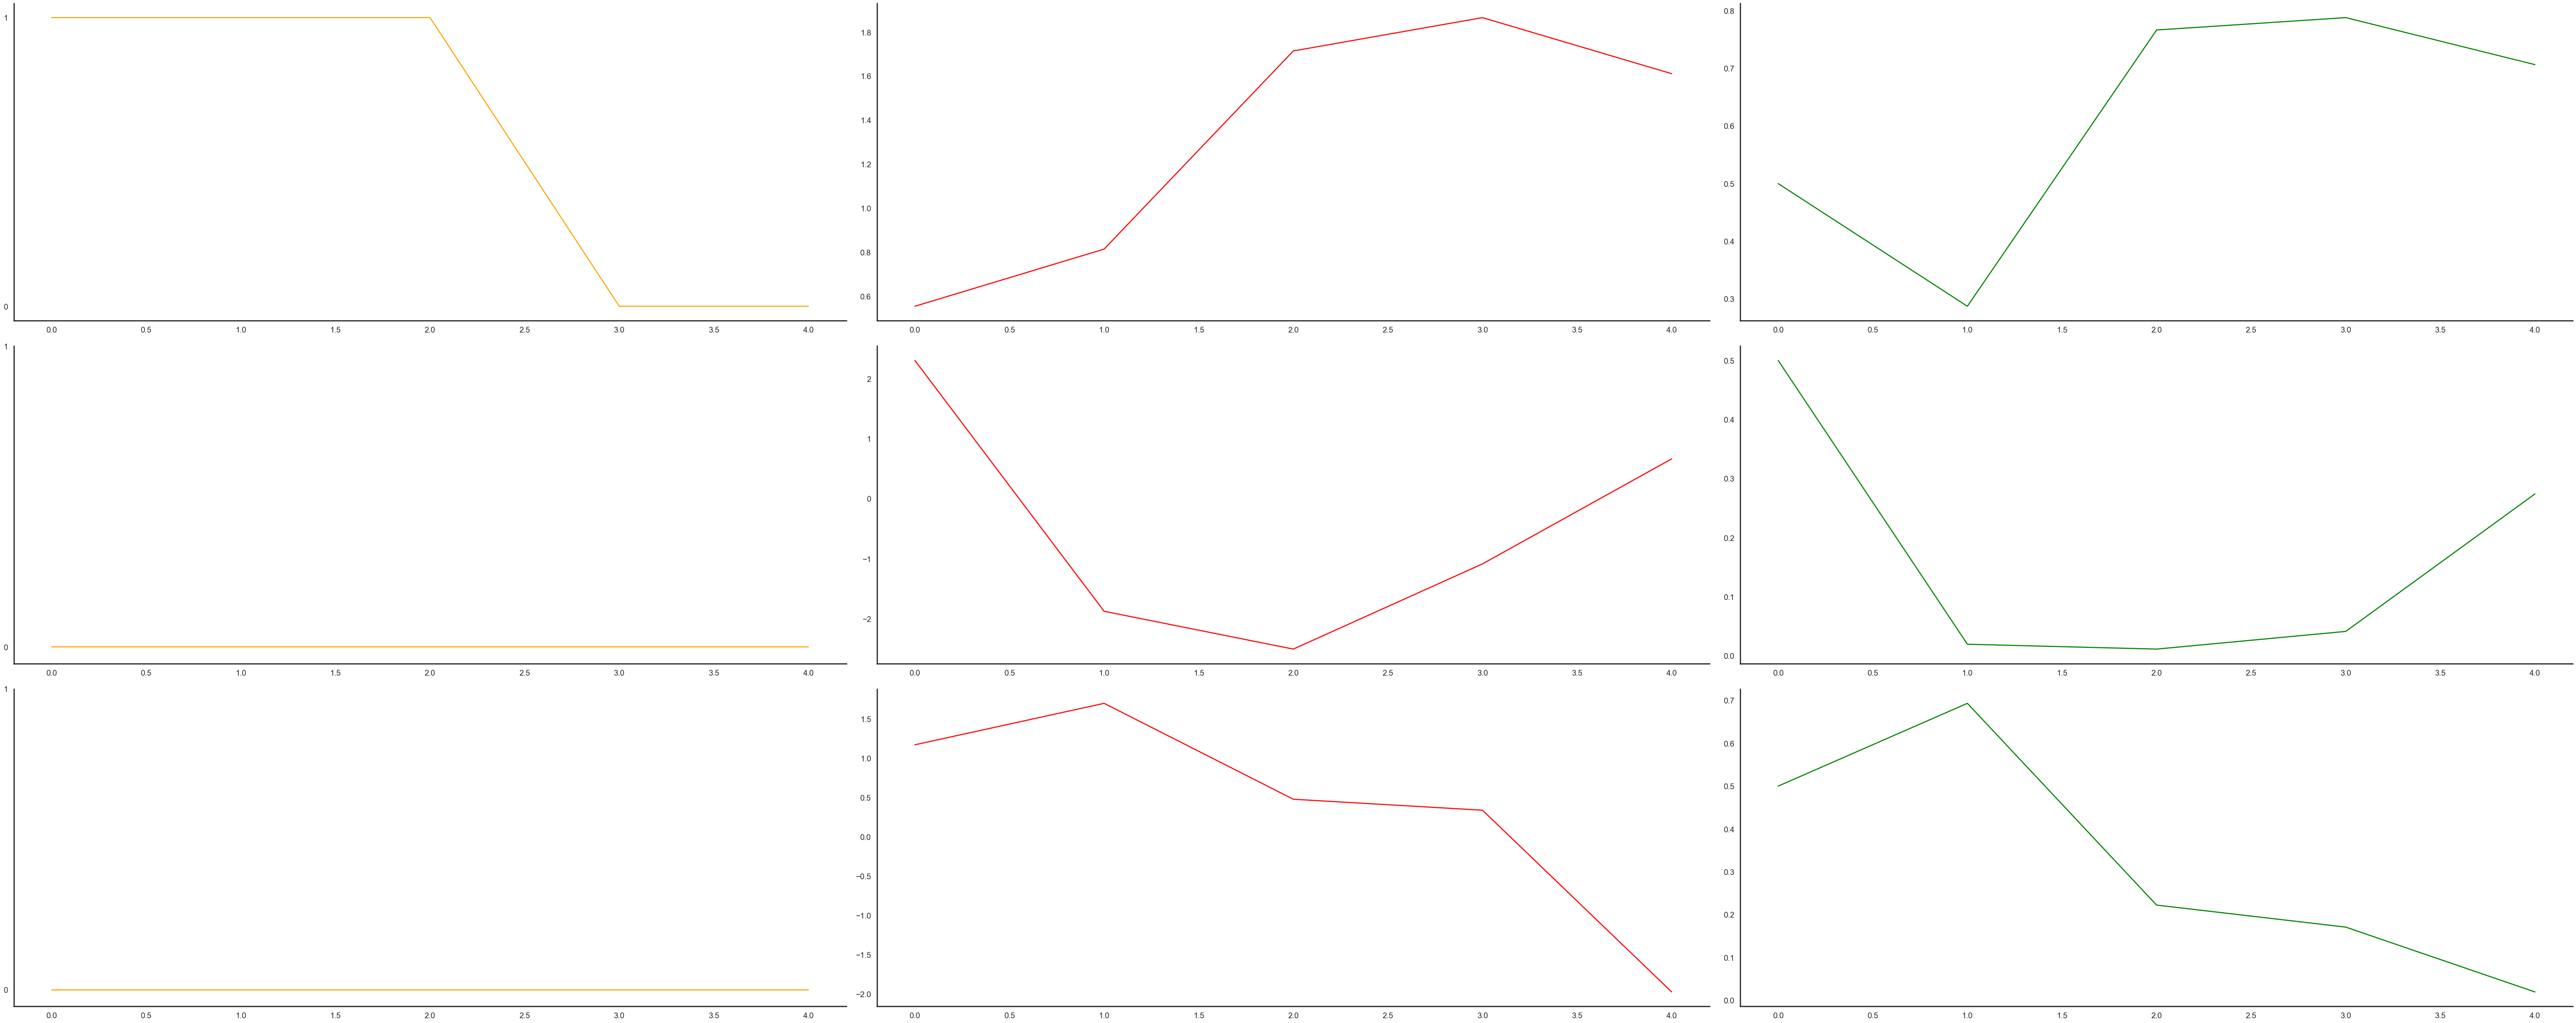

In [1280]:
bints.snapshot(N=2,T=5)

In [1281]:
bints.v_step(max_iter = 300)

ELBO: tensor(-9228607., grad_fn=<NegBackward0>)
ELBO: tensor(-17258060., grad_fn=<NegBackward0>)
ELBO: tensor(-9965685., grad_fn=<NegBackward0>)
ELBO: tensor(-8666789., grad_fn=<NegBackward0>)
ELBO: tensor(-9415177., grad_fn=<NegBackward0>)
ELBO: tensor(-8313996.5000, grad_fn=<NegBackward0>)
ELBO: tensor(-8690355., grad_fn=<NegBackward0>)
ELBO: tensor(-12330675., grad_fn=<NegBackward0>)
ELBO: tensor(-11453045., grad_fn=<NegBackward0>)
ELBO: tensor(-8785323., grad_fn=<NegBackward0>)
ELBO: tensor(-8698398., grad_fn=<NegBackward0>)
ELBO: tensor(-9210508., grad_fn=<NegBackward0>)
ELBO: tensor(-12717562., grad_fn=<NegBackward0>)
ELBO: tensor(-9429219., grad_fn=<NegBackward0>)
ELBO: tensor(-9076806., grad_fn=<NegBackward0>)
ELBO: tensor(-8811564., grad_fn=<NegBackward0>)
ELBO: tensor(-9120891., grad_fn=<NegBackward0>)
ELBO: tensor(-9300466., grad_fn=<NegBackward0>)
ELBO: tensor(-9058776., grad_fn=<NegBackward0>)
ELBO: tensor(-8347660., grad_fn=<NegBackward0>)
ELBO: tensor(-8717261., grad_fn=

KeyboardInterrupt: 

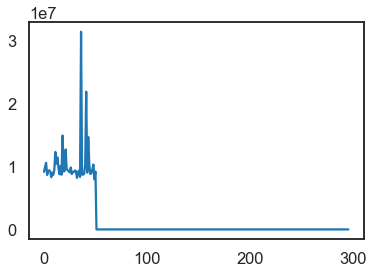

In [1282]:
elbo = bints.elbo_track
elbo = elbo.detach().numpy()

plt.plot(elbo[3:])

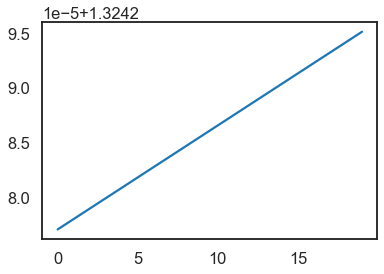

In [1283]:
mus = bints.mu_track
mus = mus.detach().numpy()
plt.plot(mus[:20,1,2])

In [1284]:
for t in np.arange(5):
    print(mus[5+t,:,:])
    plt.show()

[[-0.63615763  1.6650336   0.01590731 -0.4737027   0.3077377   0.7200373
   1.3076303   0.26915666  0.5810913   0.6941487  -0.46106243]
 [-0.21697983 -0.05365747  1.3242818  -1.0586729  -0.9931401   0.60583264
  -0.5821594   0.35249516  1.9666297   0.76470554  2.4452758 ]
 [ 0.4090641   0.26530525  0.7885369  -1.0046039   0.9088148   2.0293102
   0.44466788 -1.3331684  -0.23620197 -0.9557239   0.32182145]]
[[-0.6361566   1.6650326   0.01590631 -0.4737017   0.30773872  0.72003627
   1.3076293   0.26915768  0.5810903   0.69414973 -0.46106142]
 [-0.21698083 -0.05365847  1.3242828  -1.058672   -0.9931391   0.6058316
  -0.5821604   0.35249618  1.9666288   0.76470655  2.4452767 ]
 [ 0.4090631   0.26530424  0.7885379  -1.0046029   0.9088138   2.0293093
   0.44466686 -1.3331674  -0.23620297 -0.95572287  0.32182246]]
[[-0.6361556   1.6650317   0.01590531 -0.47370067  0.30773973  0.72003525
   1.3076284   0.2691587   0.58108926  0.69415075 -0.4610604 ]
 [-0.21698183 -0.05365947  1.3242837  -1.05

In [1285]:
var = bints.var_track
var = var.detach().numpy()

for t in np.arange(100):
    print((var[t,0,1,1]))

1.1652882
1.165289
1.1652888
1.1652871
1.165285
1.1652845
1.1652842
1.1652839
1.1652837
1.1652842
1.1652844
1.165285
1.1652857
1.1652868
1.1652876
1.1652884
1.165289
1.1652889
1.1652883
1.165288
1.1652876
1.1652871
1.1652873
1.165287
1.1652874
1.1652874
1.1652874
1.1652873
1.1652875
1.1652875
1.165288
1.1652887
1.16529
1.1652913
1.1652925
1.1652933
1.1652937
1.1652944
1.1652949
1.1652957
1.1652964
1.1652968
1.1652966
1.1652964
1.1652967
1.1652964
1.1652958
1.1652956
1.1652956
1.1652956
1.165296
1.1652964
1.1652966
1.1652963
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


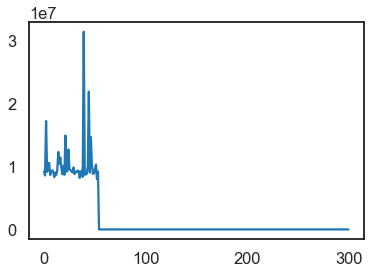

In [1286]:
elbo = bints.elbo_track
elbo = elbo.detach().numpy()

plt.plot(elbo)

In [1119]:
torch.logdet(torch.randn(4,5,5))

tensor([-2.0205,     nan,  0.3656,     nan])

In [37]:
test_tensor = torch.ones(3,3,3, requires_grad=True)

In [38]:
sum([torch.trace(test_tensor[i,:,:]) for i in [0,1,2]])

tensor(9., grad_fn=<AddBackward0>)

In [66]:
test_rand = torch.randn(100,500,500)
print(test_rand.size())
print(torch.transpose(test_rand,1,2).size())
test = torch.matmul(torch.transpose(test_rand,1,2),(test_rand))

torch.Size([100, 500, 500])
torch.Size([100, 500, 500])


In [67]:
torch.linalg.inv(test)

tensor([[[ 4.9610e-01, -6.4050e-01, -7.2119e-01,  ..., -6.7646e-01,
          -2.7167e-01,  2.9456e-01],
         [-6.4118e-01,  3.2614e+00,  3.0588e+00,  ...,  2.5481e+00,
           3.5097e-01, -1.0345e+00],
         [-7.2188e-01,  3.0588e+00,  3.2114e+00,  ...,  2.6615e+00,
           4.5648e-01, -1.0072e+00],
         ...,
         [-6.7689e-01,  2.5477e+00,  2.6610e+00,  ...,  2.5693e+00,
           3.9945e-01, -7.5434e-01],
         [-2.7164e-01,  3.5041e-01,  4.5592e-01,  ...,  3.9911e-01,
           3.5894e-01, -1.5814e-01],
         [ 2.9481e-01, -1.0345e+00, -1.0072e+00,  ..., -7.5448e-01,
          -1.5836e-01,  5.1217e-01]],

        [[ 3.6572e+00,  3.5503e+00,  8.8190e+00,  ...,  8.4348e-01,
          -1.9196e+00, -6.6087e+00],
         [ 3.5474e+00,  7.2606e+00,  1.1318e+01,  ...,  2.0607e+00,
          -2.5000e+00, -9.3960e+00],
         [ 8.8159e+00,  1.1322e+01,  2.4390e+01,  ...,  2.8587e+00,
          -5.0825e+00, -1.8841e+01],
         ...,
         [ 8.4246e-01,  2

In [72]:
test_rand = torch.randn(100,500,500)
torch.diagonal(test_rand,offset=0,dim1=1,dim2=2).size()

torch.Size([100, 500])

In [81]:
test_rand = torch.randn(3,2,2)
diag=torch.diagonal(test_rand,offset=0,dim1=1,dim2=2)

In [82]:
test_rand

tensor([[[-1.5646, -0.7833],
         [-1.7117,  0.3276]],

        [[-0.8303,  0.0450],
         [ 1.1279,  0.4819]],

        [[-0.5348,  1.1944],
         [ 0.1372, -0.5897]]])

In [80]:
diag

tensor([[-0.1289, -1.7666],
        [ 0.2539,  0.5153],
        [ 0.4156,  0.4509]])

In [84]:
test_tensor = torch.randn(10,3)

In [87]:
torch.logsumexp(test_tensor,0)

tensor([2.7843, 2.0885, 3.0844])

In [94]:
test_A = torch.randn(3,4,5)
test_B = torch.randn(4,5)
test_C = torch.randn(4,5)
test_sum = test_A*test_B+test_C

In [97]:
test_logsumexp=torch.logsumexp(test_sum,dim=1)
test_logsumexp.size()

torch.Size([3, 5])

In [98]:
test_logsumexp.mean(dim=0)

tensor([3.3093, 1.4108, 1.5996, 1.2998, 1.8811])

In [736]:
random = torch.rand(1,20)

In [740]:
torch.rand(2,20)

tensor([[0.7014, 0.8128, 0.6603, 0.8607, 0.7604, 0.6884, 0.1507, 0.3193, 0.1355,
         0.6050, 0.4354, 0.5966, 0.3180, 0.3160, 0.7712, 0.2188, 0.7460, 0.2234,
         0.9248, 0.6090],
        [0.2269, 0.8555, 0.9056, 0.7597, 0.0608, 0.4778, 0.1905, 0.5188, 0.7575,
         0.7863, 0.9069, 0.4735, 0.6435, 0.9730, 0.3125, 0.0366, 0.9225, 0.1295,
         0.0821, 0.4522]])

In [747]:
(torch.triu(torch.ones(2,10,10),0)-torch.triu(torch.ones(2,10,10),2))*torch.rand()

tensor([[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.,

In [853]:
T=5
rand_test = torch.rand(3,2*T-1)

In [854]:
rand_nu = rand_test[:,:T]
rand_omega = rand_test[:,T:]
print(rand_omega)

tensor([[0.2410, 0.4603, 0.6554, 0.5228],
        [0.4333, 0.5123, 0.3845, 0.2436],
        [0.2226, 0.3082, 0.2528, 0.7287]])


In [855]:
rand_nu

tensor([[0.4705, 0.9579, 0.1635, 0.3771, 0.8907],
        [0.9538, 0.7966, 0.8848, 0.7706, 0.7015],
        [0.1622, 0.5497, 0.4864, 0.0714, 0.7976]])

In [856]:
torch.diag_embed(rand_nu)+torch.diag_embed(rand_omega,offset=1)

tensor([[[0.4705, 0.2410, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.9579, 0.4603, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1635, 0.6554, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.3771, 0.5228],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.8907]],

        [[0.9538, 0.4333, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7966, 0.5123, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.8848, 0.3845, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7706, 0.2436],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7015]],

        [[0.1622, 0.2226, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5497, 0.3082, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4864, 0.2528, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0714, 0.7287],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7976]]])

In [1033]:
bints.data.mean(axis=0).shape

(2, 10)

(50, 2)